In [94]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf 
from keras.engine.topology import Layer
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, Add, Flatten, LSTM, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D, Lambda, Multiply, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model
from keras import regularizers
from keras.preprocessing import sequence
import keras.backend as K
import numpy as np
from keras.datasets import imdb
import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [95]:
import importlib
importlib.reload(preprocessing)

<module 'preprocessing' from 'D:\\jupyter-workdir\\nlp\\bg_fusion\\preprocessing.py'>

In [96]:
import os.path as osp
import pickle
wordCounter = preprocessing.WordCounter()
if not osp.isfile("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list"):
    wordCounter.fit(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_neg.txt", "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_pos.txt"])
    pickle.dump(wordCounter.words_list, open("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list", "wb"))
else:
    wordCounter.words_list = pickle.load(open("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list", "rb"))

In [4]:
if False:
    import gensim
    if not osp.isfile("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec"):
        sentences = gensim.models.word2vec.PathLineSentences("E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test/")
        model = gensim.models.Word2Vec(sentences, size=200, window=5, min_count=1, workers=8)
        model.save("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec")
    else:
        model = gensim.models.Word2Vec.load("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec")
    emdedings = wordCounter.get_pretrain_embedding(model, num_words=10000)

In [5]:
print("words count", len(wordCounter.words_list))

words count 181924


In [6]:
def getdata(num_words=None):
    state = np.random.RandomState(0)
    X_train_pos = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_pos.txt"], max_words=num_words))
    X_train_neg = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_neg.txt"], max_words=num_words))
    y_train_pos = np.ones(X_train_pos.shape[0])
    y_train_neg = np.zeros(X_train_neg.shape[0])
    X_test_pos = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/test_pos.txt"], max_words=num_words))
    X_test_neg = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/test_neg.txt"], max_words=num_words))
    y_test_pos = np.ones(X_test_pos.shape[0])
    y_test_neg = np.zeros(X_test_neg.shape[0])
    X_train, y_train = np.concatenate([X_train_pos, X_train_neg]), np.concatenate([y_train_pos, y_train_neg])
    X_test, y_test = np.concatenate([X_test_pos, X_test_neg]), np.concatenate([y_test_pos, y_test_neg])
    train_permut = state.permutation(X_train.shape[0])
    test_permut = state.permutation(X_test.shape[0])
    return (X_train[train_permut], y_train[train_permut]), (X_test[test_permut], y_test[test_permut])

def ignore_highfreq_words(X_train, X_test, thresh = 1e-4):
    state = np.random.RandomState(0)
    wordsStat = wordCounter.getWordsStatistics(np.concatenate([X_train, X_test]), sample = thresh)
    for i, doc in enumerate(X_train):
        X_train[i] = [w for w in doc if w in wordsStat and wordsStat[w].sample_int > state.rand() * 2 ** 32]
    for i, doc in enumerate(X_test):
        X_test[i] = [w for w in doc if w in wordsStat and wordsStat[w].sample_int > state.rand() * 2 ** 32]
    return X_train, X_test, wordsStat

In [7]:
# (X_train, y_train), (X_test, y_test) = imdb.load_data(path="E:/paper/stackingmodel/imdb/imdb.npz", num_words=10000)
num_words = 30000
(X_train, y_train), (X_test, y_test) = getdata(num_words=num_words)

In [8]:
# X_train, X_test, wordsStat = ignore_highfreq_words(X_train, X_test, thresh = 0.001)

In [9]:
# # padding 
maxlen = 800
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

In [10]:
# X_train = preprocessing.WordCounter.ngram_one_hot(n_vocab=num_words, documents_indices=X_train)
# X_test = preprocessing.WordCounter.ngram_one_hot(n_vocab=num_words, documents_indices=X_test)

In [11]:
class SpatialPyramidPooling1D(Layer):
    def __init__(self, pool_list, mode = "max", **kwargs):
        self.pool_list = np.array(pool_list)
        self.mode = mode
        assert self.pool_list.ndim == 1, "pool_list ndim must be 1"
        assert self.mode in ["max", "avg"], "mode must be either max or avg"
        self.num_outputs = sum(pool_list)
        super(SpatialPyramidPooling1D, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.gram_size = input_shape[2]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_outputs * self.gram_size)
    
    def get_config(self):
        config = {'pool_list': self.pool_list, "mode": self.mode}
        base_config = super(SpatialPyramidPooling1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x):
        input_shape = K.shape(x)
        gram_length = [K.cast(input_shape[1], 'float32') / i for i in self.pool_list]
        outputs = []
        for pool_index, num_pool_regions in enumerate(self.pool_list):
            for ix in range(num_pool_regions):
                x1 = ix * gram_length[pool_index]
                x2 = ix * gram_length[pool_index] + gram_length[pool_index]
                x1 = K.cast(K.round(x1), 'int32')
                x2 = K.cast(K.round(x2), 'int32')
                # new_shape = [input_shape[0], x2 - x1, input_shape[2]]
                x_crop = x[:, x1:x2, :]
                # x_crop = K.reshape(x_crop, new_shape)
                if self.mode == "max":
                    pooled_val = K.max(x_crop, axis=1)
                elif self.mode == "avg":
                    pooled_val = K.mean(x_crop, axis=1)
                outputs.append(pooled_val)
        outputs = K.concatenate(outputs)
        return outputs

In [12]:
# unsupport dynamic input size
class KMaxPooling1D(Layer):
    def __init__(self, pool_list, mode = "max", padding = "VALID", keepdim = False, **kwargs):
        self.pool_list = np.array(pool_list)
        self.mode = mode
        assert self.pool_list.ndim == 1, "pool_list ndim must be 1"
        assert self.mode in ["max", "avg"], "mode must be either max or avg"
        self.num_outputs = sum(pool_list)
        self.padding = padding
        self.keepdim = keepdim
        super(KMaxPooling1D, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.gram_size = input_shape[2]
    
    def compute_output_shape(self, input_shape):
        if not self.keepdim:
            return (input_shape[0], self.num_outputs * self.gram_size)
        else:
            return (input_shape[0], self.num_outputs, self.gram_size)
    
    def get_config(self):
        config = {'pool_list': self.pool_list, "mode": self.mode, "padding": self.padding, "keepdim": self.keepdim}
        base_config = super(KMaxPooling1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x):
        input_shape = x.get_shape()
        input_shape_list = input_shape.as_list()
        outputs = []
        gram_length = [input_shape_list[1] / float(i) for i in self.pool_list]
        x = tf.expand_dims(x, 3)
        for pool_index, num_pool_regions in enumerate(self.pool_list):
            ph = np.round(gram_length[pool_index]).astype(np.int32)
            sh = ph
            if self.mode == "max":
                pool_result = tf.nn.max_pool(x,
                                             ksize=[1, ph, 1, 1], 
                                             strides=[1, sh, 1, 1],
                                             padding=self.padding)
            elif self.mode == "avg":
                pool_result = tf.nn.avg_pool(x,
                                             ksize=[1, ph, 1, 1], 
                                             strides=[1, sh, 1, 1],
                                             padding=self.padding)
            outputs.append(tf.squeeze(pool_result, [3]))
        outputs = K.concatenate(outputs, axis=1)
        if not self.keepdim:
            outputs = tf.reshape(outputs, (-1, outputs.shape[1].value * outputs.shape[2].value))
        return outputs

In [13]:
class SentenceGenerator(object):
    def __init__(self, X, y, batch_size = 125, bins_count=100, mode="train", onehot = False):
        self.batch_size = batch_size
        padding_mode = "random" if mode == "train" else "specific"
        self.pool = preprocessing.AutoPaddingInMemorySamplePool(X, chunk_size=batch_size, bins_count=bins_count, mode=padding_mode)
        self.y = y[self.pool.sorted_indices]
        self.mode = mode
        self.y_indices_record = []
        self.onehot = onehot
        if self.onehot:
            onehot_encoder = OneHotEncoder()
            self.y = self.y.reshape((-1, 1))
            self.y = onehot_encoder.fit_transform(self.y).toarray()
    
    def iter(self):
        return self
    
    def reset(self):
        self.pool.reset()
        self.y_indices_record = []
    
    def __next__(self):
        batch_samples = self.pool.__next__()
        if self.mode == "test":
            self.y_indices_record.extend(self.pool.chunk_indices_list)
        return batch_samples, self.y[self.pool.chunk_indices_list]
    
    def get_test_y(self, steps):
        return self.y[self.y_indices_record[: steps * self.batch_size]]
onehot = True
batch_size = 64
bins_count = 100
SentGener_train_all = SentenceGenerator(batch_size=batch_size, X=X_train, y=y_train, mode="train", bins_count=bins_count, onehot=onehot)
SentGener_train = SentenceGenerator(batch_size=batch_size, X=X_train[:22000], y=y_train[:22000], mode="train", bins_count=bins_count, onehot=onehot)
SentGener_val = SentenceGenerator(batch_size=batch_size, X=X_train[22000:], y=y_train[22000:], mode="test", bins_count=bins_count, onehot=onehot)
SentGener_test = SentenceGenerator(batch_size=batch_size, X=X_test, y=y_test, mode="test", bins_count=bins_count, onehot=onehot)

In [14]:
print(SentGener_train.pool.min_gap, SentGener_test.pool.min_gap, SentGener_train_all.pool.steps, SentGener_train.pool.steps, SentGener_test.pool.steps, min(SentGener_train_all.pool.bins_lens))

220 250 400 400 400 800


In [15]:
callbacks = [EarlyStopping('val_loss', patience=5, mode="min"), ModelCheckpoint("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5", monitor="val_acc", save_best_only=True)]

In [16]:
def relaxed_hinge_loss(y_true, y_pred):
    y_true_minus_one = y_true - 1
    y_true_weighted = -1 * (y_true + y_true_minus_one)
    sum_term = 1 + K.sum(y_true_weighted * y_pred, axis=-1)
    return K.mean(K.maximum(sum_term, 0.))
def conv(knum, ksize, t):
    return Conv1D(knum, ksize, padding='same', activation='relu')(t)
def flat_sum(t, axis=1):
    return Lambda(lambda x: K.expand_dims(K.sum(x, axis=axis), [axis]))(t)

In [17]:
def get_spp_embeding_model_shallow_fixed(pool_list, doc_words, num_words, mode = "avg", embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 64
    x_flow_list.extend([conv(conv_ksize, i, x_flow) for i in range(1, 11)])
    # ==============================================================================
    x_flow = Concatenate(axis=1)(x_flow_list)
    x_flow = KMaxPooling1D(pool_list=pool_list, mode=mode)(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def get_spp_embeding_model_shallow(pool_list, num_words, mode = "avg", word_size = 100, embedings = None):
    word_indices = Input(shape=[None], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, word_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, word_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 4, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 5, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 6, padding='same', activation='relu')(x_flow))
    # ==============================================================================
    x_flow = Concatenate(axis=1)(x_flow_list)
    x_flow = SpatialPyramidPooling1D(pool_list=pool_list, mode=mode)(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [18]:
def get_rnn_model_shallow(doc_words, num_words, word_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, word_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, word_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ===============================Conv Layers===============================================
    x_flow_list = []
    x_flow_list.append(Conv1D(128, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(128, 3, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(128, 4, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(128, 5, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(128, 6, padding='same', activation='relu')(x_flow))
    # ================================Dense Layers=============================================
    # x_flow = Concatenate(axis=1)([x_flow_a, x_flow_b, x_flow_c, x_flow_d, x_flow_e])
    x_flow = Add()(x_flow_list)
    x_flow = LSTM(128, dropout=0.2, recurrent_dropout=0.2, unroll=True)(x_flow)
    x_flow = Dense(128, activation='relu')(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # =========================================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def get_spp_bow_conv_embeding_model_shallow(pool_list, num_words, mode = "avg"):
    word_indices = Input(shape=[None, num_words], name="word_indices", sparse=False)
    x_flow = word_indices
    x_flow_list = []
    # ==============================================================================
    x_flow_list.append(Conv1D(100, 1, padding='same', activation='relu')(x_flow))
    # ==============================================================================
    x_flow = x_flow_list[0]
    x_flow = SpatialPyramidPooling1D(pool_list=pool_list, mode=mode)(x_flow)
    x_flow = Dense(128, activation='relu')(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [19]:
def get_spp_embeding_model_middle(doc_words, num_words, embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # =====================================N-Gram=========================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, padding='same', activation='relu')(x_flow))
    x_flow = Concatenate(axis=1)(x_flow_list)
    # =====================================Attention=========================================
    attention_units = 100
    x_attention = GlobalAveragePooling1D()(x_flow)
    x_attention = Dense(attention_units, activation='softmax')(x_attention)
    x_attention = Lambda(lambda x: K.expand_dims(x, [2]))(x_attention)
    # =====================================Dense=========================================
    x_flow = KMaxPooling1D(pool_list=[attention_units], mode="max", keepdim=True)(x_flow)
    x_flow = Multiply()([x_flow, x_attention])
    x_flow = Lambda(lambda x: K.sum(x, axis=1))(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [29]:
# embedings = K.get_session().run(spp_model.layers[1].embeddings)
# np.save("E:/kaggle/avito/imdb_testset/imdb_embedding_size_300_words_30000", embedings)
# embedings = np.load("E:/kaggle/avito/imdb_testset/imdb_embedding_size_300_words_30000.npy")

In [21]:
# spp_model = get_spp_embeding_model_middle(doc_words=maxlen, num_words=num_words, embed_size=300)
spp_model = get_spp_embeding_model_shallow_fixed(pool_list=[1, 2, 5, 10, 15, 20, 25], doc_words=maxlen, num_words=num_words, embed_size=300, mode="max")
spp_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_indices (InputLayer)       (None, 800)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 800, 300)     9000000     word_indices[0][0]               
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 800, 64)      19264       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 800, 64)      38464       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [22]:
spp_model.fit_generator(SentGener_train_all, steps_per_epoch=SentGener_train_all.pool.steps, epochs=50, shuffle=True, verbose=1,
                       validation_data=SentGener_test, validation_steps=SentGener_test.pool.steps, callbacks=callbacks[1:])

Epoch 1/50
400/400 [==============================] - 97s 242ms/step - loss: 0.3242 - acc: 0.8502 - val_loss: 0.2683 - val_acc: 0.8877
Epoch 2/50
400/400 [==============================] - 92s 231ms/step - loss: 0.1015 - acc: 0.9639 - val_loss: 0.2736 - val_acc: 0.8957
Epoch 3/50
400/400 [==============================] - 92s 231ms/step - loss: 0.0273 - acc: 0.9921 - val_loss: 0.3065 - val_acc: 0.8980
Epoch 4/50
400/400 [==============================] - 92s 230ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.3273 - val_acc: 0.9025
Epoch 5/50
400/400 [==============================] - 92s 230ms/step - loss: 5.6102e-04 - acc: 1.0000 - val_loss: 0.3459 - val_acc: 0.9026
Epoch 6/50
400/400 [==============================] - 91s 228ms/step - loss: 2.3904e-04 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9022
Epoch 7/50
400/400 [==============================] - 92s 230ms/step - loss: 1.5000e-04 - acc: 1.0000 - val_loss: 0.3715 - val_acc: 0.9027
Epoch 8/50
400/400 [=======================

KeyboardInterrupt: 

In [23]:
spp_model.load_weights("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5")

In [24]:
SentGener_test.reset()
test_y_hat = spp_model.predict_generator(SentGener_test, steps=SentGener_test.pool.steps, verbose=1)

400/400 [==============================] - 18s 45ms/step


In [25]:
misclassfied_index = np.where(np.round(np.argmax(test_y_hat, axis=1)) != np.argmax(SentGener_test.y, axis=1))[0]

In [26]:
misclassfied_index[:10]

array([ 32,  45,  54,  66,  75, 103, 117, 126, 148, 150], dtype=int64)

In [139]:
index = [117]
print(wordCounter.reverse(X_test[index], num_words=30000))
print("label", SentGener_test.y[index])
print("predict", test_y_hat[index])

["that pretty much sums it up ... corny. macdowell ' s inability to act is at times painful , and hurt must need money to take such muted roles , but i still enjoyed it. why ? in a single word , unk he is great in this movie. still , i can ' t give the movie too high a score , but it certainly deserves better than it seems to be getting. unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk 

In [ ]:
def round_test():
    callbacks[0].best = np.inf
    callbacks[1].best = np.inf
    for i in range(10):
        print("==========round-%s" % i)
        spp_model.fit_generator(SentGener_train_all, steps_per_epoch=SentGener_train_all.pool.steps, epochs=5, shuffle=True, verbose=1)
        SentGener_test.reset()
        test_y_hat = spp_model.predict_generator(SentGener_test, steps=SentGener_test.pool.steps, verbose=1)
        acc = accuracy_score(SentGener_test.y, np.round(test_y_hat + 1e-5))
        print("==========round-%s, accuracy: %s" % (i, acc))
    # spp_model.load_weights("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5")

In [ ]:
i2w_dict = wordCounter.get_i2w_dictionary(num_words=num_words)
w2i_dict = wordCounter.get_w2i_dictionary(num_words=num_words)

In [136]:
def get_2dvec(vectors):
    from sklearn.manifold import TSNE
    tsne = TSNE(perplexity=30, n_components=2)
    low_dim_embs = tsne.fit_transform(vectors)
    return low_dim_embs

def plot_vectors(vectors):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(12, 12))
    plt.scatter(vectors[:, 0], vectors[:, 1])
    plt.yticks(np.arange(-50, 40, 10))
    plt.xticks(np.arange(-50, 50, 10))
    plt.grid(True, linestyle='-.')
    plt.show()
    
def plot_vectors_comp(vectors, compare_words):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(12, 12))
    compare_vec = []
    for w in compare_words:
        if w in w2i_dict:
            vec = low_dim_embs[w2i_dict[w]]
            plt.annotate(w, xy=(vec[0], vec[1]), xytext=(5, 2), textcoords='offset points', ha="right", va="bottom", color="k")
            compare_vec.append(vec)
    compare_vec = np.array(compare_vec)
    plt.scatter(vectors[:, 0], vectors[:, 1])
    plt.scatter(compare_vec[:, 0], compare_vec[:, 1], c="g")
    plt.yticks(np.arange(-50, 40, 10))
    plt.xticks(np.arange(-50, 50, 10))
    plt.grid(True, linestyle='-.')
    plt.show()

In [43]:
low_dim_embs = get_2dvec(embedings[:num_words])

In [44]:
np.save("E:/kaggle/avito/imdb_testset/imdb_embedding_2d", low_dim_embs)

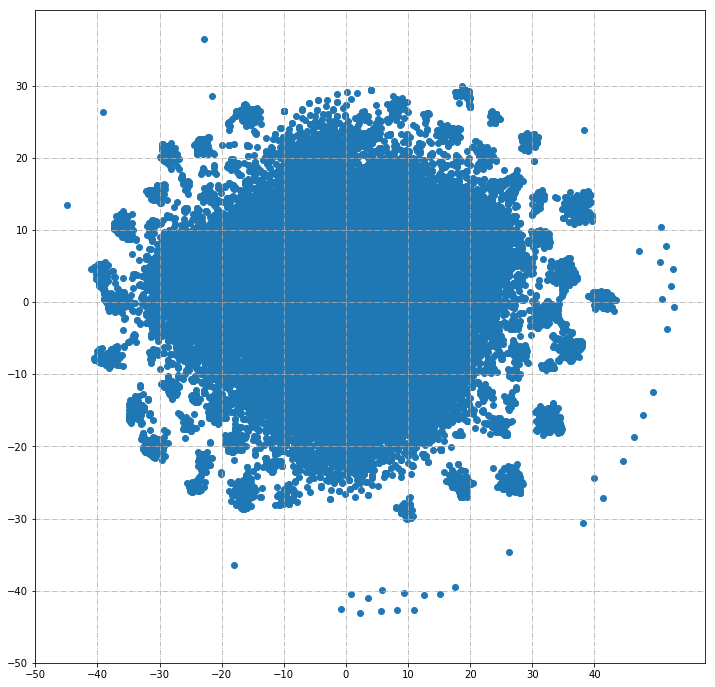

In [111]:
plot_vectors(low_dim_embs)

In [91]:
# find grid cluster
cond = [-20, -10, -40, -30]
loc = np.where(
    (low_dim_embs[:, 0] > cond[0]).astype(np.int32) * (low_dim_embs[:, 0] < cond[1]).astype(np.int32)
    * (low_dim_embs[:, 1]> cond[2]).astype(np.int32) * (low_dim_embs[:, 1] < cond[3]).astype(np.int32)) [0]

In [92]:
# min, max, avg
print(np.min(low_dim_embs[loc], axis=0), np.max(low_dim_embs[loc], axis=0), np.average(low_dim_embs[loc], axis=0))

[-18.026093 -36.48107 ] [-18.026093 -36.48107 ] [-18.026093 -36.48107 ]


In [98]:
# cluster words
for l in loc: print(l, i2w_dict[l])

28747 mesmerised


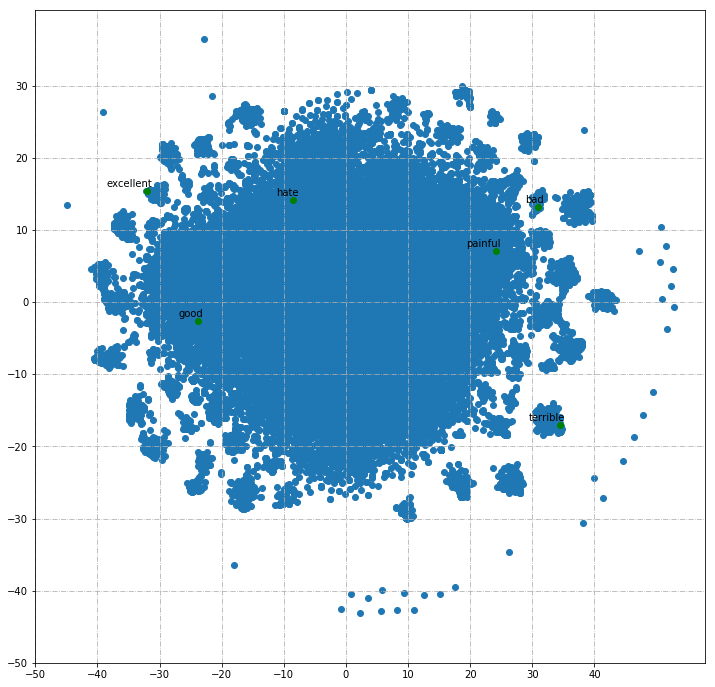

In [141]:
# compare
plot_vectors_comp(low_dim_embs, ["terrible", "bad", "good", "excellent", "hate", "painful"])